# ECSE 415 - Project - Emile Riberdy 260985547

This report is for reporting purposes only, and contains code that is mostly runnable on a local machine, and not on collab, due to the difficulties of Google drive for handling videos. It is best to run the code with the provided python file as such:

```

pip install -r requirements.txt
python project3.py [1|2]

```

where 1 corresponds to the mcgill_drive.mp4 video and 2 corresponds to the st-catherines_drive.mp4 video.

You can change the path of the videos in their corresponding code blocks.

## Approach

For this assignment, the approach taken was to first detect objects in each frame of each videos using the YOLOv8 model. To achieve this, the Supervision package was used coupled with the ultralytics YOLOv8 model. The supervision package comes with a built-in object tracker, and image annotator that can easily track and annotate detected image in an image. Furthermore, their API provides easy-to-use tools for video processing.

Once we have object detection, we can leverage the above mentioned tracker from Supervision to keep track of each unique cars or pedestrians encountered. 

Furthermore, the tracker allows us to track the position (centroid) of each detected unique objects. This position is used to estimate the number of parked cars by averaging the displacement of an object between each frame. Parked cars should in general have a displacement that is close to the average of the mean displacement of all objects, since cars that are moving in the same direction as the cam have low displacements in the image, and cars moving in the opposite direction will have higher mean displacement. Based on those assumptions, we then estimate the number of parked cars by taking the mean of mean displacements for each unique object detected, and taking all objects with a mean displacement that is 1/2 standard deviation or less around the mean.

While this method is definitely not the most accurate one, it was the best way to have a rough estimate that was found. 

## Implementation

In [3]:
import cv2
import supervision as sv
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm
import argparse
import sys
import matplotlib.pyplot as plt

In [6]:
#Helper function to annotate the frame with a counter for unique cars and persons

def print_car_count(unique_cars, frame):
    cv2.putText(frame, f'Unique cars: {unique_cars}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    return frame

def print_person_count(unique_persons, frame):
    cv2.putText(frame, f'Unique pedestrians: {unique_persons}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    return frame

The following function is a modified version of the tracking example from the Supervision documentation

In [ ]:
def process_video(
    source_weights_path: str,
    source_video_path: str,
    target_video_path: str,
    confidence_threshold: float = 0.3,
    iou_threshold: float = 0.7,
) -> None:

    #initialize the YOLOv8 model
    model = YOLO(source_weights_path)

    #initialize trackers used to keep track of unique cars and persons
    car_tracker = sv.ByteTrack()
    person_tracker = sv.ByteTrack()

    #initialize annotators
    person_annotator = sv.RoundBoxAnnotator()
    box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    #video utils
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path)
    video_info = sv.VideoInfo.from_video_path(video_path=source_video_path)

    #tracker ids are not necessarily in order, so we need to keep track of the labels
    car_tracker_id_to_label = {}
    car_next_label = 1
    unique_cars = 0

    # structure to store each unique car's centroid position at every frame
    car_centroids = {}

    person_tracker_id_to_label = {}
    person_next_label = 1
    unique_persons = 0

    with sv.VideoSink(target_path=target_video_path, video_info=video_info) as sink:
        for frame in tqdm(frame_generator, total=video_info.total_frames):
            results = model(
                frame, verbose=False, conf=confidence_threshold, iou=iou_threshold
            )[0]
            detections = sv.Detections.from_ultralytics(results)


            #get only cars with confidence > 0.7
            car_detections = detections[detections.class_id == 2]
            car_detections = car_detections[car_detections.confidence > 0.7]
            car_detections = car_tracker.update_with_detections(car_detections)

            #logic for getting an incrementing label for each unique car
            car_labels = []
            for tracker_id in car_detections.tracker_id:
                if tracker_id not in car_tracker_id_to_label:
                    car_tracker_id_to_label[tracker_id] = car_next_label
                    car_next_label += 1
                car_labels.append(f"Car {car_tracker_id_to_label[tracker_id]}")

            #store the centroid of each car
            for detection in car_detections:
                coords, _, _, _, tracker_id, _ = detection
                x1, y1, x2, y2 = coords
                centroid = (int((x1 + x2) / 2), int((y1 + y2) / 2))
                if tracker_id not in car_centroids:
                    car_centroids[tracker_id] = []
                car_centroids[tracker_id].append(centroid)


            #the number of unique cars is simply the number of different labels we have computed
            unique_cars = len(car_tracker_id_to_label)

            #annotate the frame with bounding boxes and labels for the output video
            annotated_frame = box_annotator.annotate(
                scene=frame.copy(), detections=car_detections
            )

            annotated_labeled_frame = label_annotator.annotate(
                scene=annotated_frame, detections=car_detections, labels=car_labels
            )

            #print the number of unique cars on the frame
            annotated_labeled_frame = print_car_count(unique_cars, annotated_labeled_frame)

            #repeat the entire process but for pedestrians (person)
            person_detections = detections[detections.class_id == 0]
            person_detections = person_detections[person_detections.confidence > 0.5]
            person_detections = person_tracker.update_with_detections(person_detections)

            person_labels = []
            for tracker_id in person_detections.tracker_id:
                if tracker_id not in person_tracker_id_to_label:
                    person_tracker_id_to_label[tracker_id] = person_next_label
                    person_next_label += 1
                person_labels.append(f"Person {person_tracker_id_to_label[tracker_id]}")

            unique_persons = len(person_tracker_id_to_label)

            annotated_frame = box_annotator.annotate(
                scene=annotated_labeled_frame.copy(), detections=person_detections
            )

            annotated_labeled_frame = label_annotator.annotate(
                scene=annotated_frame, detections=person_detections, labels=person_labels
            )

            annotated_labeled_frame = print_person_count(unique_persons, annotated_labeled_frame)

            sink.write_frame(frame=annotated_labeled_frame)

    print(f"Unique cars: {unique_cars}, Unique persons: {unique_persons}")


    for tracker_id in car_centroids:
        car_centroids[tracker_id] = np.array(car_centroids[tracker_id])

    #mean displacement vector of each car
    mean_displacement = np.zeros(len(car_centroids))
    for i, tracker_id in enumerate(car_centroids):
        if len(car_centroids[tracker_id]) < 2:
            continue
        mean_displacement[i] = np.mean(np.linalg.norm(np.diff(car_centroids[tracker_id], axis=0), axis=1))

    #replace nan values with 0
    mean_displacement = np.nan_to_num(mean_displacement)

    #get the total mean displacement and standard deviation
    total_mean_displacement = np.mean(mean_displacement)
    std = np.std(mean_displacement)

    

    print(f"Mean displacement: {total_mean_displacement}, Standard deviation: {std}")


    #get number of values inside 1/2 standard deviation
    inside_std = np.sum(np.abs(mean_displacement - total_mean_displacement) < std/2)
    print(f"Estimated number of parked cars: {inside_std}")
    print(f"Estimated number of moving cars: {unique_cars - inside_std}")

## Output

When we run this function on the videos, we get print statements for the results, as well as an output video all annotated with the corresponding bounding boxes and counters. The number of parked cars vs moving cars is evaluated once the entire video has been processed, based on all the unique cars we have tracked.

### mcgill_drive.mp4

In [23]:
video_path = "./videos/input/mcgill_drive.mp4"
output_path = "./videos/output/out_mcgill_drive.mp4"

process_video(
    source_weights_path="yolov8s.pt",
    source_video_path=video_path,
    target_video_path=output_path,
    confidence_threshold=0.5,
    iou_threshold=0.5,
)

100%|██████████| 1071/1071 [00:41<00:00, 25.73it/s]


Unique cars: 52, Unique persons: 56
Mean displacement: 14.471588055507386, Standard deviation: 11.197991426258243
Estimated number of parked cars: 23
Estimated number of moving cars: 29


This output corresponds to the algorithm being run on the mcgill_drive.mp4 videos. We get the following results:

Unique cars: Predicted = 52, Actual = 46

Unique pedestrians: Predicted = 56, Actual = 35

Parked cars: Predicted = 23, Actual = 19

Moving cars: Predicted = 29, Actual = 27

PS: The ground truth values were obtained manually by watching the video, and may be inexact

The output video can be viewed at the specified output path 

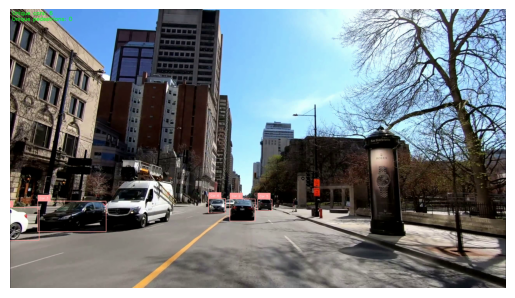

In [25]:
#display a random frame from the output video

cap = cv2.VideoCapture(output_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 60)
ret, frame = cap.read()
cap.release()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### st-catherines_drive.mp4

In [27]:
video_path = "./videos/input/st-catherines_drive.mp4"
output_path = "./videos/output/out_st-catherines_drive.mp4"

process_video(
    source_weights_path="yolov8s.pt",
    source_video_path=video_path,
    target_video_path=output_path,
    confidence_threshold=0.5,
    iou_threshold=0.5,
)

100%|██████████| 1477/1477 [00:59<00:00, 24.81it/s]

Unique cars: 66, Unique persons: 120
Mean displacement: 15.315773720974073, Standard deviation: 8.097125021478393
Estimated number of parked cars: 28
Estimated number of moving cars: 38


This output corresponds to the algorithm being run on the mcgill_drive.mp4 videos. We get the following results:

Unique cars: Predicted = 66, Actual = 67

Unique pedestrians: Predicted = 120, Actual = 108

Parked cars: Predicted = 28, Actual = 59

Moving cars: Predicted = 38, Actual = 8

PS: The ground truth values were obtained manually by watching the video, and may be inexact

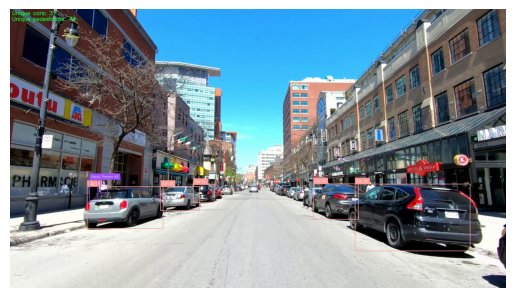

In [29]:
#display a random frame from the output video

cap = cv2.VideoCapture(output_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 500)
ret, frame = cap.read()
cap.release()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Discussion of program performance and problems

This algorithm uses the YOLOv8 model, which is good for real-time processing like video analysis since it is fast. However, it can be less accurate in its object detection than other models like R-CNN. An implementation using R-CNN was attempted, but it was found that the processing of a video was too long for the purpose of this assignment. Therefore, a less accurate but faster YOLOv8 model was preferred.

Because we loose some accuracy, the algorithm is not 100% accurate, but still gives a good estimation for the number of unique cars and pedestrians. The model often counted bikers as persons, adding to the count of pedestrians counted. Overall the pedestrian detection was deemed acceptable.

The count of unique cars also provided good results, almost predicting the ground truth value obtained in both videos. 

The estimation for the number of parked vs moving cars is the weaker part of this algorithm. As can be seen from the result, the approach taken might not have been the good one. We can see that in the 2nd video (St-Catherine), since there are a majority of parked cars, the mean displacement of centroids is heavily skewed towards the speed of parked cars, making hard to differentiate between moving and parked cars with the mean and half standard deviation taken. However, since the distribution of parked vs moving cars is more spread in the first video (McGill), we get a better estimation for the number of parked cars.

Overall, this algorithm provides good speed and acceptable accuracy for use cases such as analyzing a dashcam video for the number of unique cars and pedestrians encounter. However, the approach taken to count the number of parked cars might need to be reevaluated for more general usage.